In [1]:
import pyedflib
import numpy as np

import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter
%matplotlib inline

In [2]:
file_name = "./data/chb01_03.edf"
f = pyedflib.EdfReader(file_name)
n = f.signals_in_file
signal_labels = f.getSignalLabels()
sigbufs = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)

In [3]:
sr = 256
batch_size = 64
preictal_time = 20 * 60 * sr

siez_starts = [2996, 1467, 1732, 1015, 1720, 327, 1862]
siez_starts = [siez_starts[i] * sr for i in range(len(siez_starts))]
siez_ends = [3036, 1494, 1772, 1066, 1810, 420, 1963]
siez_ends = [siez_ends[i] * sr for i in range(len(siez_ends))]
file_names = ["chb01_03.edf", "chb01_04.edf", "chb01_15.edf", "chb01_16.edf", "chb01_18.edf", "chb01_21.edf", "chb01_26.edf"]

In [4]:
ch_names = ["FP1-F7",
" F7-T7",
" T7-P7",
" P7-O1",
" FP1-F3",
" F3-C3",
" C3-P3",
" P3-O1",
" FP2-F4",
" F4-C4",
" C4-P4",
" P4-O2",
" FP2-F8",
" F8-T8",
" T8-P8",
" P8-O2",
" FZ-CZ",
" CZ-PZ", 
" P7-T7", " T7-FT9", "FT9-FT10", "FT10-T8","T8-P8"]

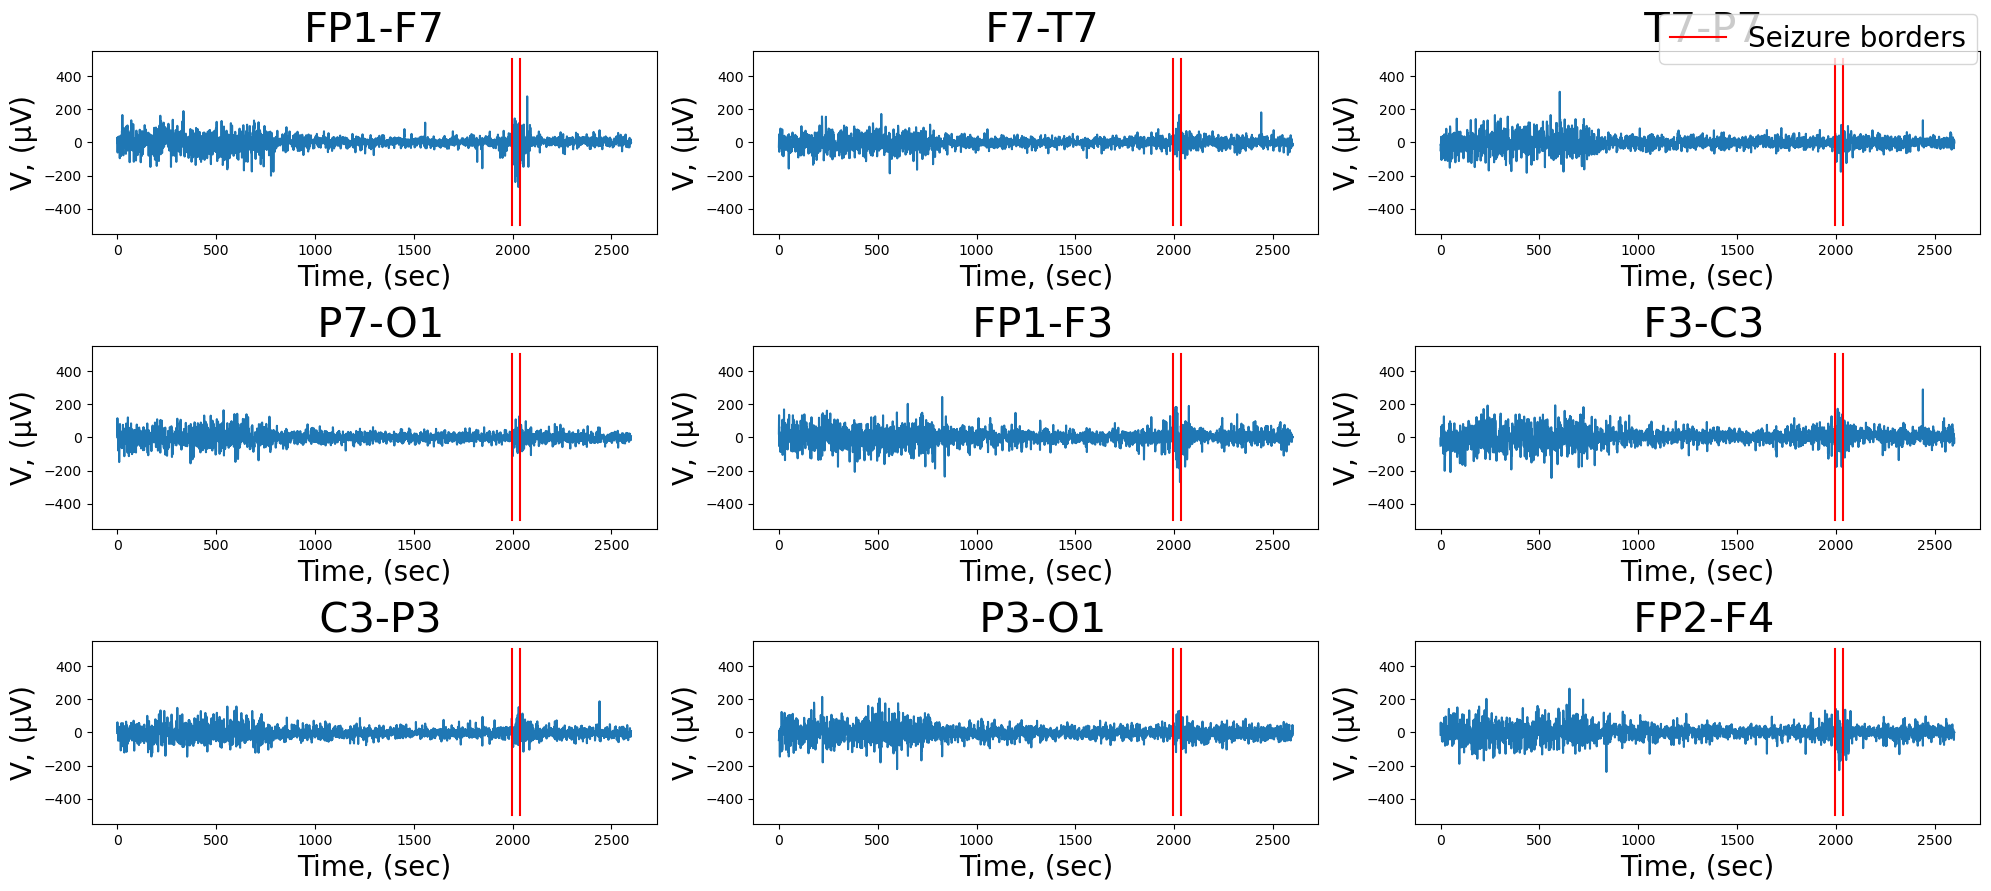

In [47]:

fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 9))

l1 = None
for i in range(3):
    for j in range(3):
        ax[i, j].plot(sigbufs[i*3 + j][::256][1000:])
        l1 = ax[i, j].plot([2996 - 1000]*2, [-500, 500], c="red", label="Seizure borders")
        ax[i, j].plot([3036 - 1000]*2, [-500, 500], c="red")
        ax[i, j].set_title(ch_names[i*3 + j], size = 30)
        ax[i, j].set_xlabel("Time, (sec)", size = 20)
        ax[i, j].set_ylabel("V, (μV)", size = 20)
        
fig.legend(handles = l1, labels=["Seizure borders"],
           loc="upper right", fontsize =20)        
fig.tight_layout()

In [44]:
l1

In [5]:
data = sigbufs[0]
data = gaussian_filter(data, sigma=3, radius=5)
train = data[:400000]
test =  data[400000:500000]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [16]:
mean

0.17347554172363655

In [17]:
std

45.68189960086121

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Floating
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

In [7]:
lstm_train = data[:400000]
lstm_test =  data[400000:500000]

mean = lstm_train.mean()
std = lstm_train.std()
#sigmastest = np.abs(test - mean)
train_norm = (lstm_train - mean)/std
test_norm = (lstm_test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [8]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_norm, train_window)
test_inout_seq = create_inout_sequences(test_norm, train_window)

In [9]:
train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=False, drop_last=True)

In [13]:
model_lstm = LSTMModel(input_size=1, hidden_layer_size=100, num_layers=2, output_size=1, dropout=0)
model_lstm = model_lstm.to('cuda')

In [14]:
def run_epoch(model, dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        y = y.view(-1).to('cuda')

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)


    return epoch_loss

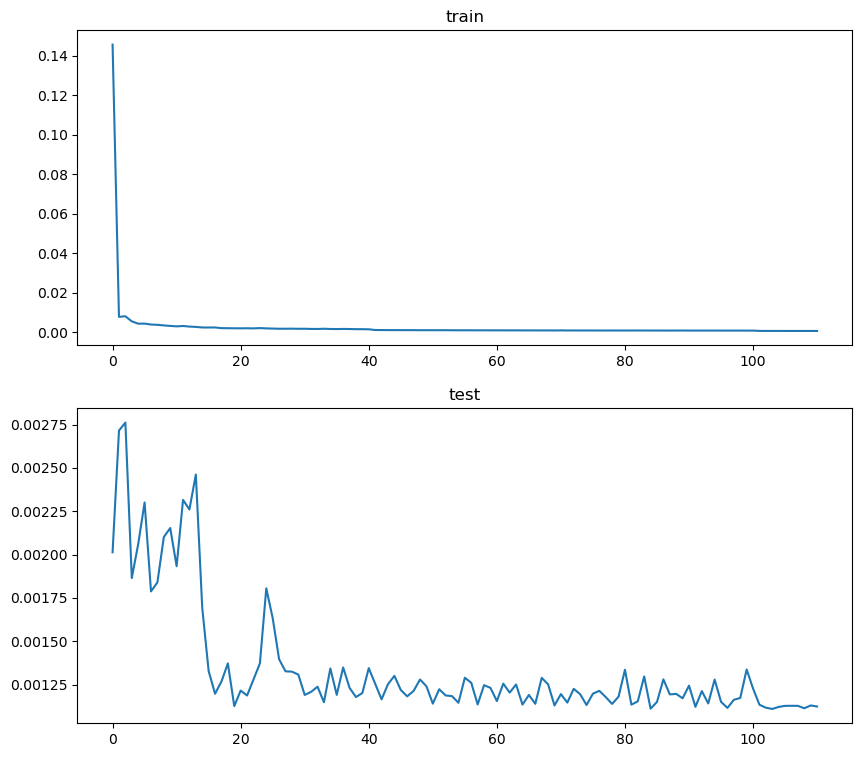

Epoch[111/175] | loss train:0.000574, test:0.001123


KeyboardInterrupt: 

In [15]:
# define optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-9)
lr = 0.001
epochs = 175

losses_train = []
losses_test = []
best_loss = 10e9
# begin training
for epoch in range(epochs): 
    if epoch > 40:
        lr = 0.0005
    if epoch > 100:
        lr = 0.0001
    optimizer = optim.Adam(model_lstm.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-9)    
    loss_train = run_epoch(model_lstm, train_dataloader, is_training=True)
    loss_val = run_epoch(model_lstm, test_dataloader)
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    if losses_test[-1] < best_loss:
        best_loss = losses_test[-1]
        torch.save(model_lstm.state_dict(), "./LSTMChildrenSiezNoDropoutFiltered")
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, epochs, loss_train, loss_val))

In [11]:
model_lstm.load_state_dict(torch.load("LSTMChildrenSiezNoDropoutFiltered"))

RuntimeError: Error(s) in loading state_dict for LSTMModel:
	size mismatch for linear_1.weight: copying a param with shape torch.Size([100, 23]) from checkpoint, the shape in current model is torch.Size([100, 1]).
	size mismatch for linear_2.weight: copying a param with shape torch.Size([23, 200]) from checkpoint, the shape in current model is torch.Size([1, 200]).
	size mismatch for linear_2.bias: copying a param with shape torch.Size([23]) from checkpoint, the shape in current model is torch.Size([1]).

In [ ]:
def GetRmse(model, train_dataloader, val_dataloader, lstm_test, std, mean):
    model.eval()

    rmse = []
    
    lstm_predicts = []
    for k in tqdm(range(1, 20)):
        test_right_part = (len(lstm_test)- 20)%64
        predicted_val = np.array([])
        for idx, (x, y) in enumerate(val_dataloader):
            x = torch.reshape(x, (64, 20, 1)).to('cuda')
            cur_x = x
            for _ in range(k):
                out = model(cur_x.to('cuda'))
                cur_x = torch.hstack((cur_x[:, 1:], torch.reshape(out, (64, 1, 1))))
            predicted_val = np.concatenate((predicted_val, cur_x[:, -1, 0].cpu().detach().numpy()))
            
        lstm_predicts.append(np.array(predicted_val)*std+mean)
        if k == 1:
            r = (((np.array(predicted_val)*std+mean - np.array(lstm_test[20:-test_right_part]))**2).mean())**0.5
        else:
            r = (((np.array(predicted_val[:-k+1])*std+mean - np.array(lstm_test[20+k-1:-test_right_part]))**2).mean())**0.5
        rmse.append(r)
    return rmse, lstm_predicts

In [ ]:
rmse_chaos, lstm_predicts = GetRmse(model_lstm, train_dataloader, test_dataloader, lstm_test, std, mean)

In [12]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [22]:
lstm_predicts[0][:-0].shape

(0,)

In [24]:
test_right_part = (len(lstm_test)- 20)%64
mape = []
for i in range(len(lstm_predicts)):

    if i:
        mape.append(MAPE(lstm_test[20+i:-test_right_part], lstm_predicts[i][:-i]))
    else:
        mape.append(MAPE(lstm_test[20:-test_right_part], lstm_predicts[i]))

In [25]:
mape

[2.7173714908710114,
 11.82943725267994,
 22.287298835574212,
 53.476307535261114,
 71.01175090622995,
 116.65232619338578,
 162.63066822689538,
 192.81264417079657,
 239.92446864298734,
 322.31043581738464,
 425.7703856573245,
 452.47162143388096,
 508.0442809024687,
 562.6475375696975,
 522.5067444720501,
 525.7721256102493,
 533.137309771491,
 569.7570271013052,
 534.8212271450976]

In [2]:
mape = [2.7173714908710114,
 11.82943725267994,
 22.287298835574212,
 53.476307535261114,
 71.01175090622995,
 116.65232619338578,
 162.63066822689538,
 192.81264417079657,
 239.92446864298734,
 322.31043581738464,
 425.7703856573245,
 452.47162143388096,
 508.0442809024687,
 562.6475375696975,
 522.5067444720501,
 525.7721256102493,
 533.137309771491,
 569.7570271013052,
 534.8212271450976]

Text(0.5, 0, 'prediction step')

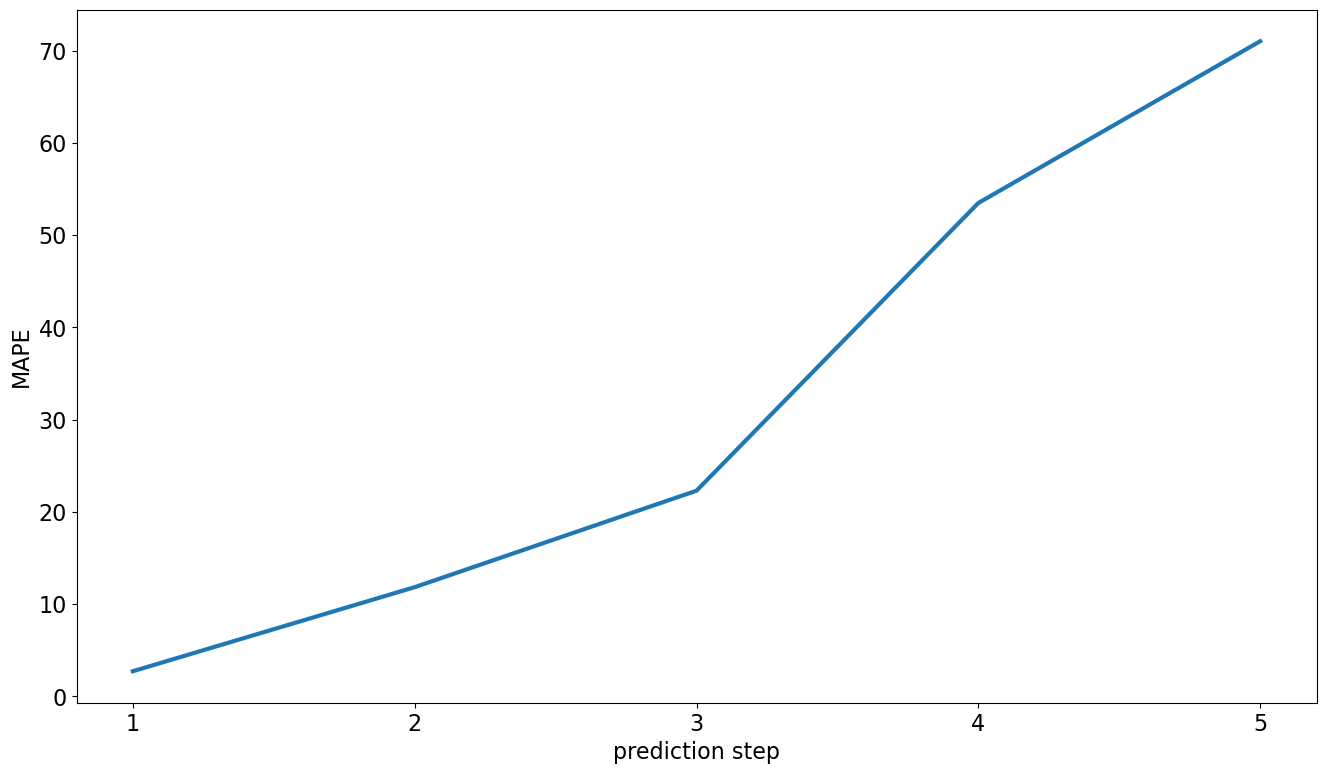

In [3]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(list(range(1, 6)), mape[:5], linewidth=3)

#ax.legend()
ax.tick_params(axis='both', which='major', labelsize=16)
#ax.set_title("RMSE",  fontsize = 16)
ax.set_ylabel("MAPE",  fontsize = 16)
ax.set_xlabel("prediction step",  fontsize = 16)

Text(0.5, 0, 'prediction step')

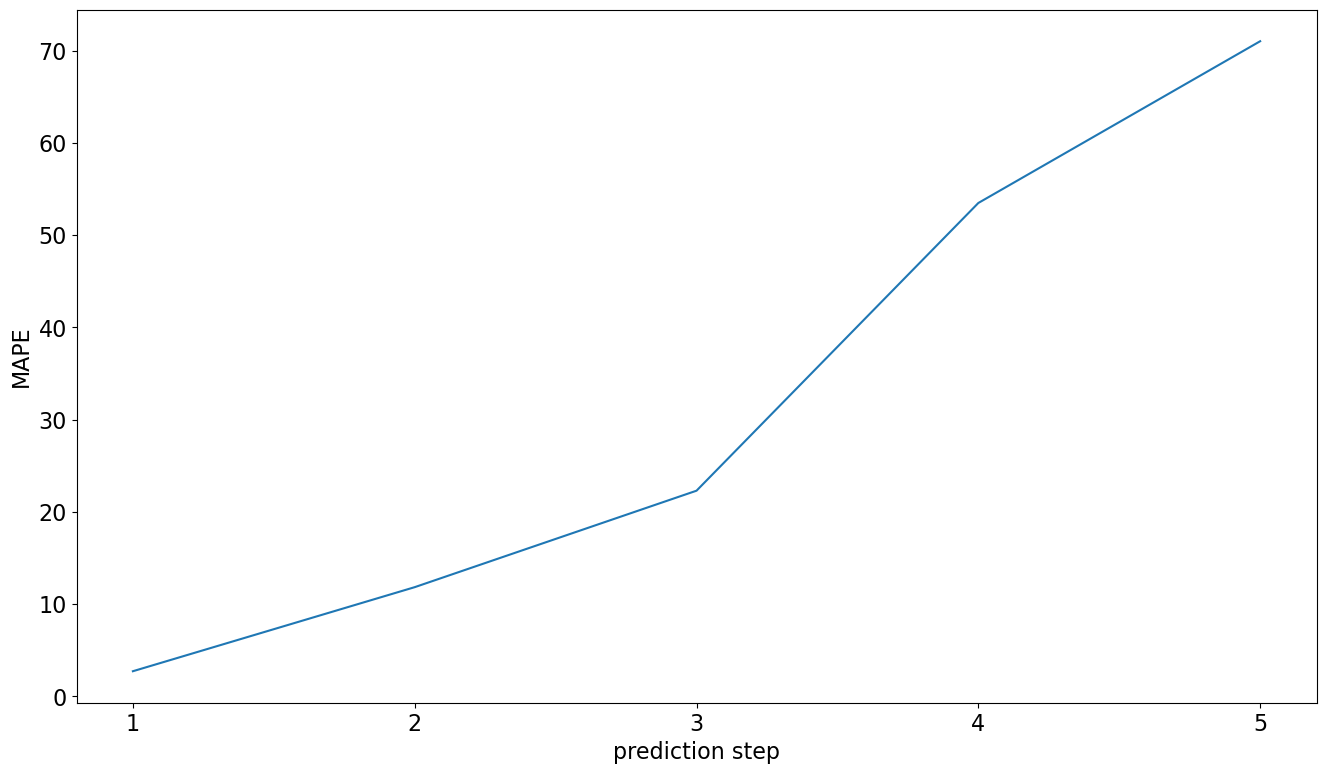

In [27]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(list(range(1, 6)), mape[:5], linewidth=3)

#ax.legend()
ax.tick_params(axis='both', which='major', labelsize=16)
#ax.set_title("RMSE",  fontsize = 16)
ax.set_ylabel("MAPE",  fontsize = 16)
ax.set_xlabel("prediction step",  fontsize = 16)

Text(0.5, 0, 'prediction step')

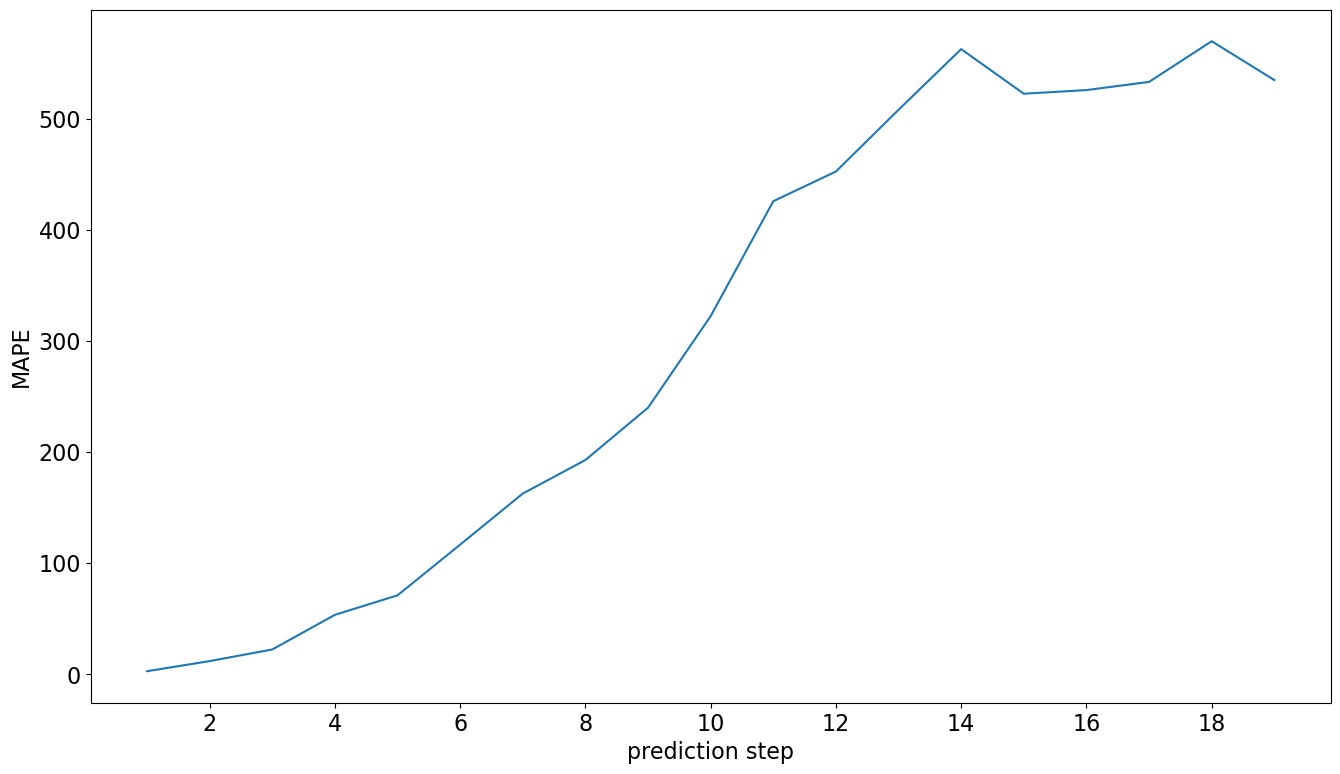

In [26]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(list(range(1, 20)), mape)

#ax.legend()
ax.tick_params(axis='both', which='major', labelsize=16)
#ax.set_title("RMSE",  fontsize = 16)
ax.set_ylabel("MAPE",  fontsize = 16)
ax.set_xlabel("prediction step",  fontsize = 16)

In [16]:
rmse_chaos

[6.345762580923378,
 8.818670886005888,
 11.325358817594681,
 14.538699185355439,
 17.62733094513718,
 20.8396275887542,
 24.566066839915358,
 28.61961162755113,
 32.61501781877925,
 36.5838092740419,
 40.47185633760145,
 44.13004968270028,
 47.51394818270169,
 50.64733439600611,
 53.495092828306994,
 56.05810999010916,
 58.51814090540617,
 60.973742460877766,
 63.33511114781128]

No dropout

Text(0.5, 0, 'prediction step')

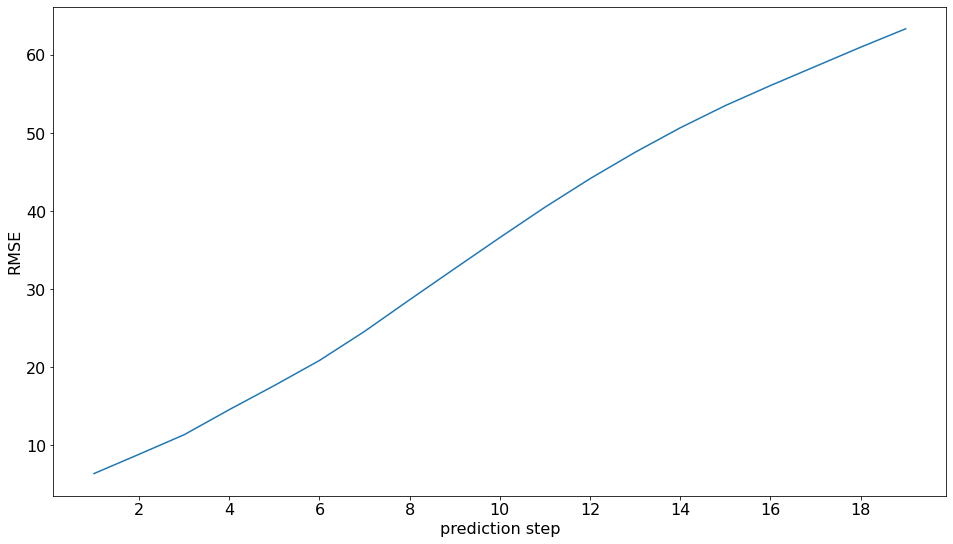

In [33]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(list(range(1, 20)), rmse_chaos)

#ax.legend()
ax.tick_params(axis='both', which='major', labelsize=16)
#ax.set_title("RMSE",  fontsize = 16)
ax.set_ylabel("RMSE",  fontsize = 16)
ax.set_xlabel("prediction step",  fontsize = 16)

Dropout

Text(0.5, 0, 'prediction step')

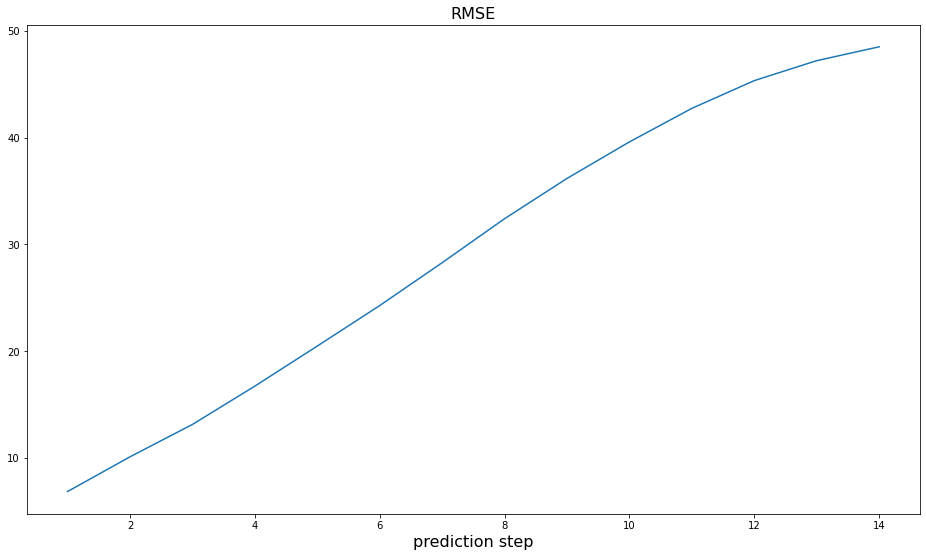

In [49]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(list(range(1, 15)), rmse_chaos[:14])

#ax.legend()
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title("RMSE",  fontsize = 16)
ax.set_xlabel("prediction step",  fontsize = 16)

In [23]:
def Plt(k):
    #k = 5
    #fig = plt.figure(figsize = (16, 16))
#     ax_1 = fig.add_subplot(3, 1, 1)
#     ax_1.plot(data[-500000 + k:-500000 + k + 1000], label='true')
#     ax_1.plot(int_to_amp(wave_net_predicts[:, 1:][k-1], data, n=256)[:1000],  linestyle = '--', label='predicted')
#     ax_1.legend()
#     ax_1.set_title('WaveNet')
    
    fig, ax = plt.subplots(figsize = (16, 9))
    ax.plot(lstm_test[20+k-1: 20+k-1 + 1000], linewidth = 3, label='истинные')
    ax.plot(lstm_predicts[k-1][:1000],  linestyle = (0, (5, 10)), linewidth = 3, label='предсказанные', color="red")
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(fontsize=16)
    ax.set_xlabel("t",  fontsize = 16)
    ax.set_ylabel("V, µV",  fontsize = 16)
    ax.set_title('LSTM',  fontsize = 16)
    
#     ax_3 = fig.add_subplot(3, 1, 3)
#     ax_3.plot(lstm_test[20+k-1: 20+k-1 + 1000], label='true')
#     ax_3.plot(transformer_predicts[k-1][:1000],  linestyle = '--', label='predicted')
#     ax_3.legend()
#     ax_3.set_title('Transformer')
    plt.show()
    

### Filtered

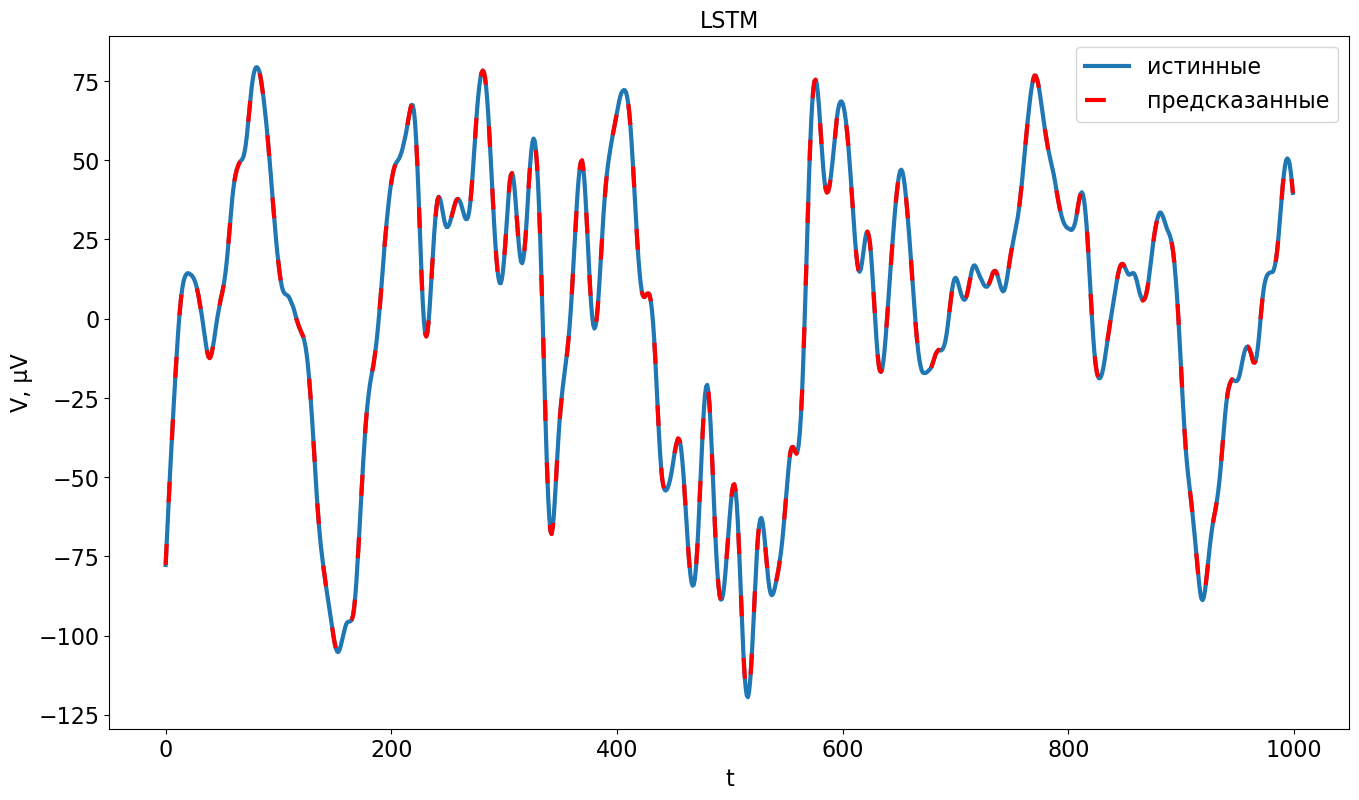

In [24]:
Plt(1)

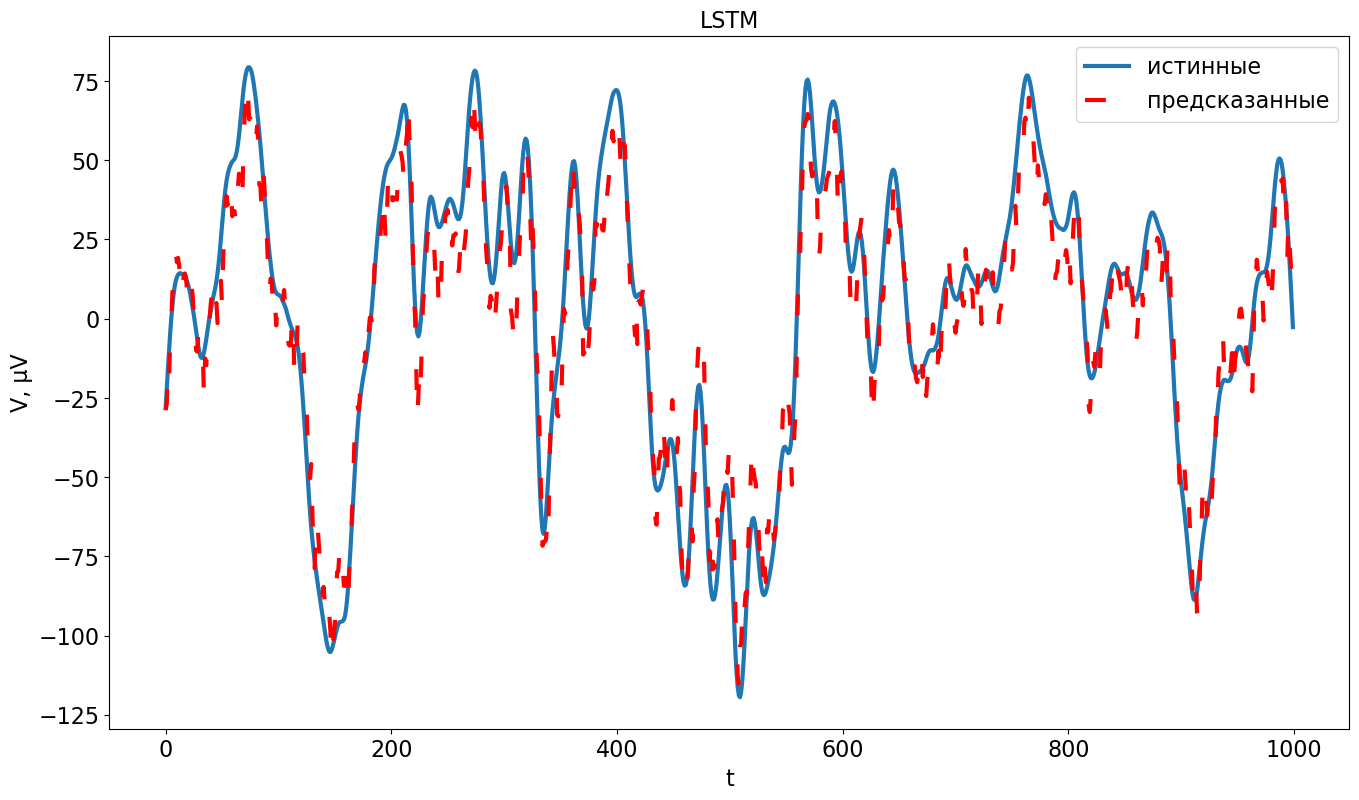

In [26]:
Plt(8)

No dropout

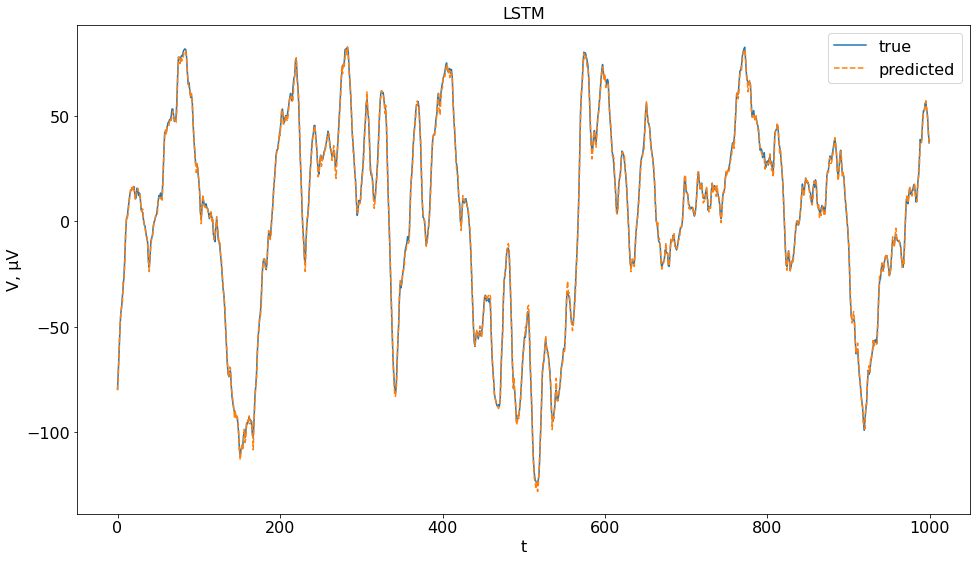

In [35]:
Plt(1)

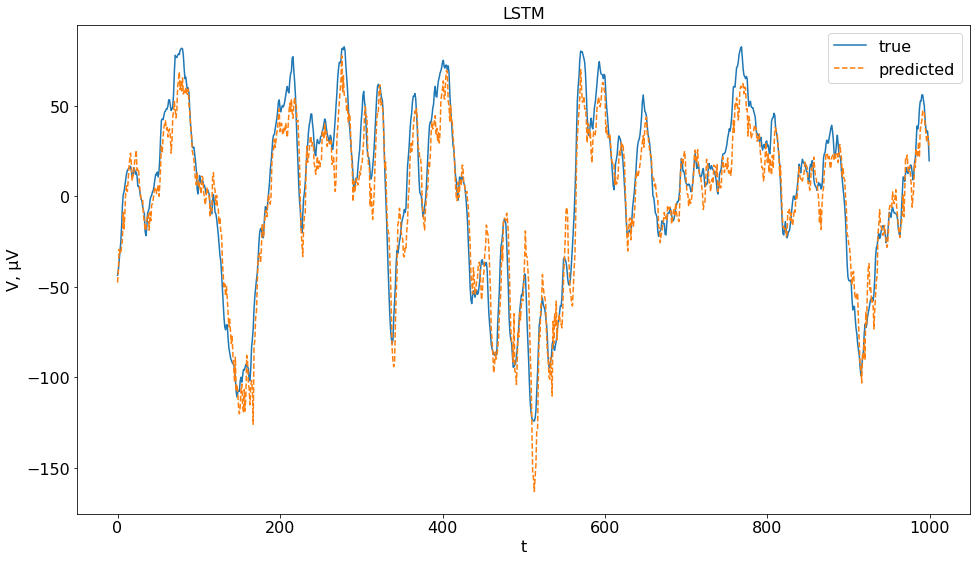

In [36]:
Plt(5)

Dropout

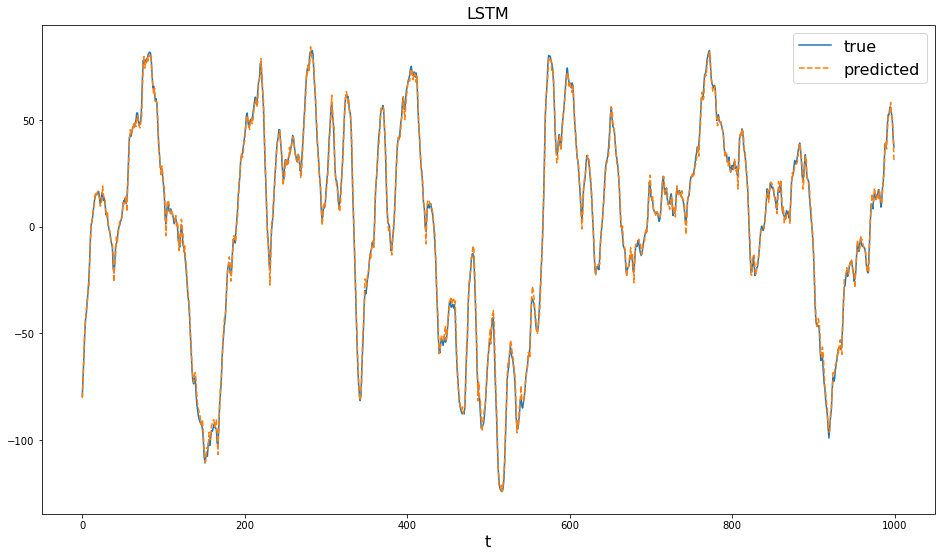

In [60]:
Plt(1)